<a href="https://colab.research.google.com/github/PawinData/UC/blob/SFBA/Temporal_Spatial_validated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functions import str_to_day, day_to_str, check_missing, shortest_path
from geopy.distance import vincenty

In [0]:
# 9 counties of the San Francisco Bay Area
COUNTIES = ["San Francisco", "Alameda",  "Contra Costa", "Marin", "Napa", 
            "San Mateo", "Santa Clara", "Solano", "Sonoma"]
COUNTIES.sort()

place = "SF Bay Area"

STATE = "California"

## By changing the state and the list of county names above, one can apply the analysis below to any county-level subset of the original COVID-19 dataset released by New York Times.

# **Data Preparation**

In [4]:
# get the raw data
df = pd.read_csv('https://query.data.world/s/7ifvvpyy23sa2fciuvcygehakxlnnv')

# only look at California
df = df.loc[df["state"]==STATE]

# extract data for the 9 counties
DATA = pd.DataFrame(df.loc[df['county']==COUNTIES[0]], index=None)
for cnty in COUNTIES[1:]:
    DATA = DATA.append(df.loc[df["county"]==cnty], ignore_index=True)
        
print(DATA.shape)
DATA

(460, 6)


,date,county,state,fips,cases,deaths
0,2020-03-01,Alameda,California,6001.0,1,0
1,2020-03-02,Alameda,California,6001.0,1,0
2,2020-03-03,Alameda,California,6001.0,2,0
3,2020-03-04,Alameda,California,6001.0,2,0
4,2020-03-05,Alameda,California,6001.0,2,0
...,...,...,...,...,...,...
455,2020-04-08,Sonoma,California,6097.0,123,1
456,2020-04-09,Sonoma,California,6097.0,136,1
457,2020-04-10,Sonoma,California,6097.0,145,2
458,2020-04-11,Sonoma,California,6097.0,145,2


In [8]:
# find the time window of observation
t = list(DATA["date"])
t.sort()
print("The start of observation:", t[0])
print("The end of observation:", t[-1])

k_obs = str_to_day(t[-1])-str_to_day(t[0])+1

The start of observation: 2020-01-31
The end of observation: 2020-04-12


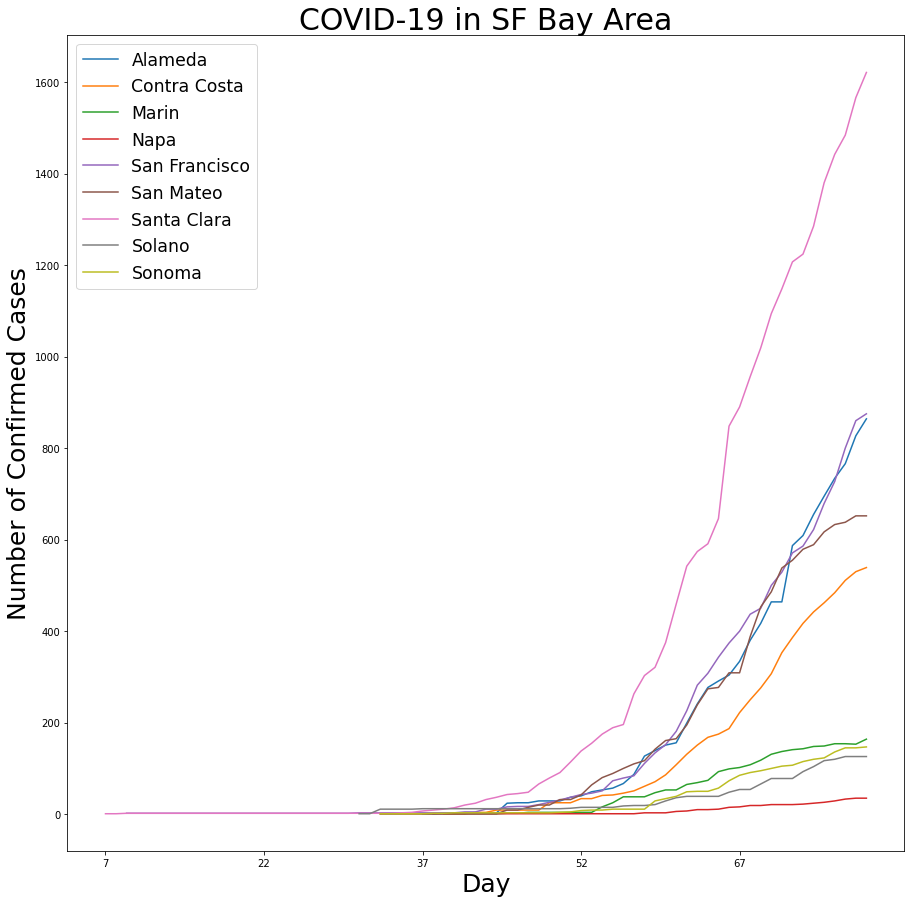

In [9]:
# plot the dynamics of confirmed cases for each county
plt.figure(figsize=(15,15))
for cnty in COUNTIES:
    data = DATA.loc[DATA["county"]==cnty]
    plt.plot([str_to_day(D) for D in data["date"]], data["cases"])
plt.xticks(np.arange(str_to_day(t[0]), str_to_day(t[-1]), step=15))
plt.title("COVID-19 in "+place, fontsize=30)
plt.xlabel("Day", fontsize=25)
plt.ylabel("Number of Confirmed Cases", fontsize=25)
plt.legend(COUNTIES, loc="upper left", fontsize="xx-large")
plt.show()

In [10]:
# check if the report of confirmed cases has been incessant in the counties
for cnty in COUNTIES:
    print(cnty, "has no missing data: ", check_missing(DATA.loc[DATA["county"]==cnty]["date"]))

Alameda has no missing data:  True
Contra Costa has no missing data:  True
Marin has no missing data:  True
Napa has no missing data:  True
San Francisco has no missing data:  True
San Mateo has no missing data:  True
Santa Clara has no missing data:  True
Solano has no missing data:  True
Sonoma has no missing data:  True


In [11]:
D = dict()    # store the adjacenty between counties
population = dict()   # store the population of each county
COORD = dict()  # store the longitude and lattitude of the city hall of the most populous city in each county

for cnty in COUNTIES:    # input info manually for each county
    adj = input("What counties is "+cnty+" adjacent to? (Separate counties by comma)\n")
    D[cnty] = adj.split(",")   # a list of counties that this specific county is adjacent to
    pop = input("What is the population of "+cnty+"?\n")
    population[cnty] = int(pop)
    coord = input("What are the coordinates of the city hall of the most populous city in "+cnty+"?\nType in a tuple:")
    coord = coord.split(",")
    COORD[cnty] = (float(coord[0]), float(coord[1]))

What counties is Alameda adjacent to? (Separate counties by comma)
Contra Costa, Santa Clara, Santa Clara, San Mateo
What is the population of Alameda?
1671329
What are the coordinates of the city hall of the most populous city in Alameda?
Type in a tuple:37.805943, -122.272286
What counties is Contra Costa adjacent to? (Separate counties by comma)
Solano, Marin, Alameda, San Francisco
What is the population of Contra Costa?
1153526
What are the coordinates of the city hall of the most populous city in Contra Costa?
Type in a tuple:38.007900, -122.024261
What counties is Marin adjacent to? (Separate counties by comma)
Sonoma, Contra Costa, San Francisco
What is the population of Marin?
252409
What are the coordinates of the city hall of the most populous city in Marin?
Type in a tuple:37.975033, -122.531769
What counties is Napa adjacent to? (Separate counties by comma)
Sonoma, Solano
What is the population of Napa?
136484
What are the coordinates of the city hall of the most populous 

## For reasonable comparison, the number of daily new cases will be normalized by the population of each county.

In [0]:
# reorganize the data for the TCP framework
T = list()
START = dict()

for cnty in COUNTIES:
    data = DATA.loc[DATA["county"]==cnty]
    time = [str_to_day(dd) for dd in data["date"]]
    # record the date when the first case was confirmed in each county
    START[cnty] = time[0] 
    # number of cases per 1 million population   
    cases_count = [ele/(population[cnty]*0.1**6) for ele in data["cases"]]
    # focus on daily new cases rather than total case count
    cases_count = [cases_count[0]] + [cases_count[i]-cases_count[i-1] for i in range(1,len(cases_count))]
    if time[0]>str_to_day(t[0]):
        cases_count = [0] * (time[0] - str_to_day(t[0])) + cases_count
    T.append(cases_count)

# construct an array
# each row is the time series of cases count for a county    
TimeSeries = np.array(T)

In [45]:
# save the array of daily new cases per 1 million population as a dataframe
DF = pd.DataFrame(TimeSeries, index=COUNTIES, columns=[day_to_str(dd) for dd in range(str_to_day(t[0]),1+str_to_day(t[-1]))])
DF.to_csv("Daily_New_Cases.csv", sep=",")
DF

,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12
Alameda,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.598326,0.000000,0.598326,0.000000,0.000000,0.598326,0.000000,0.000000,12.564851,0.598326,0.000000,2.393305,0.000000,0.000000,4.786610,1.794979,5.384936,2.393305,2.393305,5.983262,11.966525,23.933050,7.179915,7.179915,2.991631,25.728028,25.129702,21.539745,8.376567,7.778241,17.949787,27.523007,22.138071,28.121333,0.000000,73.594128,13.163177,27.523007,23.933050,23.334723,19.146440,36.497901,22.138071
Contra Costa,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.866907,0.000000,0.000000,2.600722,0.000000,4.334536,0.000000,0.000000,0.000000,0.000000,13.870515,0.000000,0.000000,7.802165,0.000000,6.068350,0.866907,3.467629,4.334536,8.669072,8.669072,13.003608,19.071958,19.938866,17.338144,14.737422,6.068350,10.402886,30.341752,24.273402,22.539587,26.874123,39.877731,28.607938,26.874123,21.672680,17.338144,19.071958,23.406495,16.471237,7.802165
Marin,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.961824,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.961824,0.000000,7.923648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.541886,35.656415,51.503710,0.000000,0.000000,35.656415,23.770943,0.000000,47.541886,15.847295,19.809119,75.274653,23.770943,11.885472,23.770943,39.618239,51.503710,23.770943,15.847295,7.923648,19.809119,3.961824,19.809119,0.000000,-3.961824,43.580063
Napa,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,7.326866,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.653732,0.000000,0.000000,21.980598,7.326866,21.980598,0.000000,7.326866,29.307465,7.326866,21.980598,0.000000,14.653732,0.000000,0.000000,7.326866,14.653732,14.653732,21.980598,29.307465,14.653732,0.000000
San Francisco,0.000000,0.0,2.268734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.134367,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.268734,0.000000,6.806201,0.000000,5.671834,1.134367,0.000000,4.537468,5.671834,5.671834,6.806201,6.806201,3.403101,5.671834,24.956072,6.806201,5.671834,30.627906,26.090439,20.418604,32.896640,51.046510,63.524546,29.493539,39.702841,35.165374,29.493539,41.971575,14.746770,56.718345,32.896640,47.643409,17.015503,40.837208,64.658913,54.449611,82.808783,68.062014,17.015503
San Mateo,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.304507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.436058,0.000000,7.827043,6.522536,0.000000,15.654086,0.000000,13.045072,28.699158,20.872115,11.740565,14.349579,13.045072,9.131550,32.61268

# **Intra-Region Temporal Correlation**

In [0]:
H = dict()   # a histogram of pairwise delta t
S = dict()   # sum of pairwise differences over all delta t

for cnty in DF.index:               # looping through every county
    for day1 in DF.columns:             # for every two days
        t1 = str_to_day(day1)
        for day2 in DF.columns:         # compute the |diff| in number of new cases
            delta = abs(t1 - str_to_day(day2))
            if delta==0:
                continue
            H[delta] = H.get(delta,0) + 1    # count records (to compute average)
            # add up total |diff|
            S[delta] = S.get(delta,0) + abs(DF[day1][cnty] - DF[day2][cnty])

## **Plotting |$\Delta$ n| against |$\Delta$ t|**

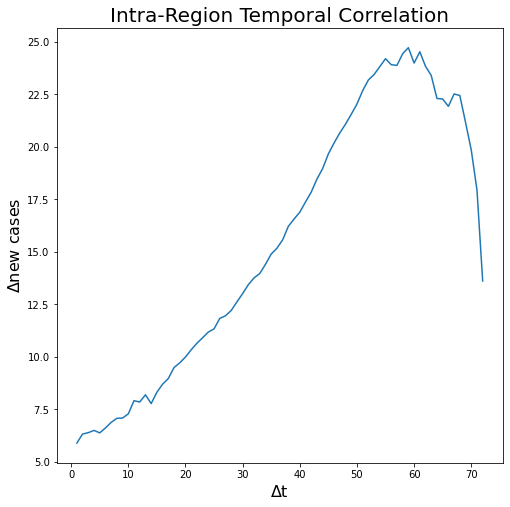

In [47]:
# plot the average |diff| against |delta t|
plt.figure(figsize=(8,8))
plt.plot(list(H.keys()), [int(S[delta])/int(H[delta]) for delta in H.keys()])
plt.title("Intra-Region Temporal Correlation", fontsize=20)
plt.xlabel("$\Delta$t", fontsize=16)
plt.ylabel("$\Delta$new cases", fontsize=16)
plt.savefig("Intra_Region_Tempo.png")
plt.savefig("Intra_Region_Tempo.eps")
plt.show()

# **Inter-Region Spatial Correlation**

## **Shortest-Networks Distance**

In [55]:
# construct adjacency matrix for the 9 counties

ADJ = dict()
for A in COUNTIES:
    clmn = list()
    for B in COUNTIES:
        if B in D[A]:
            clmn.append(1)
        else:
            clmn.append(0)
    ADJ[A] = clmn

ADJACENCY = pd.DataFrame(ADJ, index=COUNTIES)
ADJACENCY.to_csv("AdjacencyMatrix.csv", sep=",")
ADJACENCY

,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma
Alameda,0,1,0,0,1,1,1,0,0
Contra Costa,1,0,1,0,1,0,0,1,0
Marin,0,1,0,0,1,0,0,0,1
Napa,0,0,0,0,0,0,0,1,1
San Francisco,1,1,1,0,0,1,0,0,0
San Mateo,1,0,0,0,1,0,1,0,0
Santa Clara,1,0,0,0,0,1,0,0,0
Solano,0,1,0,1,0,0,0,0,0
Sonoma,0,0,1,1,0,0,0,0,0


In [56]:
# compute shortest-network distance matrix
D1 = dict()

for A in ADJACENCY.columns:
    vector = list()
    for B in ADJACENCY.index:
        vector.append(shortest_path(ADJACENCY, A, B))
    D1[A] = vector

DIST_1 = pd.DataFrame(D1, index=COUNTIES)
DIST_1

,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma
Alameda,0,1,2,3,1,1,1,2,3
Contra Costa,1,0,1,2,1,2,2,1,2
Marin,2,1,0,2,1,2,3,2,1
Napa,3,2,2,0,3,4,4,1,1
San Francisco,1,1,1,3,0,1,2,2,2
San Mateo,1,2,2,4,1,0,1,3,3
Santa Clara,1,2,3,4,2,1,0,3,4
Solano,2,1,2,1,2,3,3,0,2
Sonoma,3,2,1,1,2,3,4,2,0


## **Populous-Center Distance**

In [58]:
# compute populous-center distance matrix

D2 = dict()

for A in COUNTIES:
    vector = list()
    for B in COUNTIES:
        distance = vincenty(COORD[A],COORD[B]).km
        vector.append(round(distance,4))
    D2[A] = vector

DIST_2 = pd.DataFrame(D2, index=COUNTIES)
DIST_2

,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma
Alameda,0.0000,31.2770,29.5502,54.5197,13.2731,21.8637,62.1639,32.9403,82.8301
Contra Costa,31.2770,0.0000,44.7298,39.6200,43.0100,52.9402,75.3243,23.2263,79.2226
Marin,29.5502,44.7298,0.0000,41.5672,23.8574,31.9720,90.8373,27.7205,56.5795
Napa,54.5197,39.6200,41.5672,0.0000,58.5555,69.2022,112.2015,21.7267,42.0238
San Francisco,13.2731,43.0100,23.8574,58.5555,0.0000,10.9507,68.0130,38.4881,80.2945
San Mateo,21.8637,52.9402,31.9720,69.2022,10.9507,0.0000,65.0917,49.4105,88.3605
Santa Clara,62.1639,75.3243,90.8373,112.2015,68.0130,65.0917,0.0000,91.0481,144.8471
Solano,32.9403,23.2263,27.7205,21.7267,38.4881,49.4105,91.0481,0.0000,56.8032
Sonoma,82.8301,79.2226,56.5795,42.0238,80.2945,88.3605,144.8471,56.8032,0.0000


In [0]:
# save the distance matrices
DIST_1.to_csv("DistanceMatrix_shortestnetworks.csv", sep=",")
DIST_2.to_csv("DistanceMatrix_populous.csv", sep=",")

## **Plotting |$\Delta$ n| against |$\Delta$ d|**

In [0]:
H_1 = dict() # a histogram of pairwise shortest-network distances
S_1 = dict() # sum of pairwise differences over all distances

H_2 = dict() # a histogram of pairwise populous-center distances
S_2 = dict() # sum of pairwise differences over all distances

for date in DF.columns:
    for A in DF.index:
        for B in DF.index:
            if A==B:
                continue
            # shortest-network distance
            d1 = DIST_1[A][B]
            H_1[d1] = H_1.get(d1,0) + 1
            S_1[d1] = S_1.get(d1,0) + abs(DF[date][A] - DF[date][B])
            # populous-center distance
            d2 = DIST_2[A][B]
            H_2[d2] = H_2.get(d2,0) + 1
            S_2[d2] = S_2.get(d2,0) + abs(DF[date][A] - DF[date][B])

In [0]:
# sort by ascending distances

lst_1 = list(H_1.keys())
lst_1.sort()

lst_2 = list(H_2.keys())
lst_2.sort()

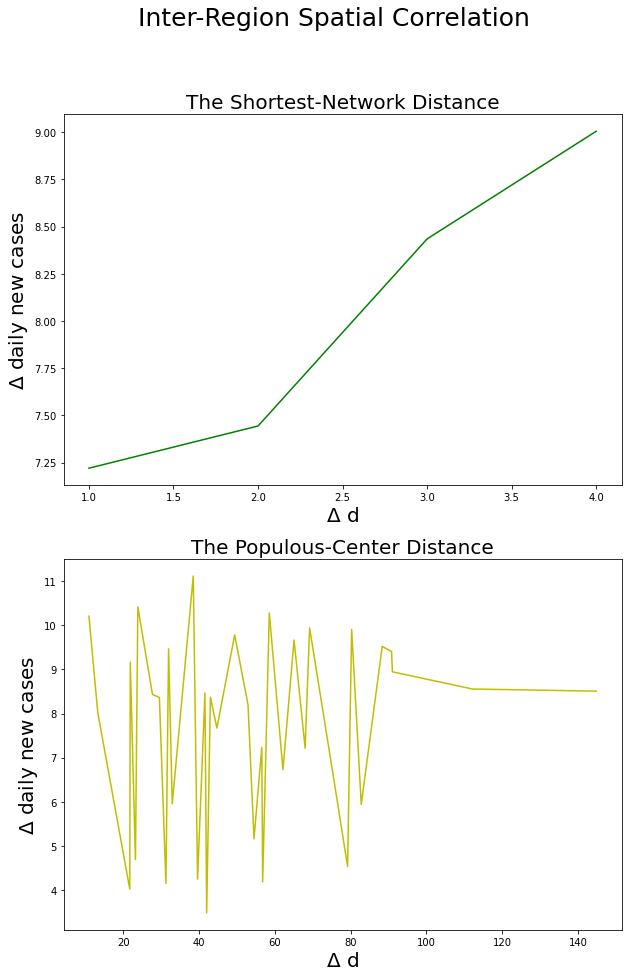

In [64]:
fig, axs = plt.subplots(2, figsize=(10,15))
fig.suptitle("Inter-Region Spatial Correlation", fontsize=25)
# the subplot for shortest-network distance
axs[0].plot(lst_1, [int(S_1[delta])/int(H_1[delta]) for delta in lst_1], 'g')
axs[0].set_title("The Shortest-Network Distance", fontsize=20)
axs[0].set_xlabel("$\Delta$ d", fontsize=20)
axs[0].set_ylabel("$\Delta$ daily new cases", fontsize=20)
# the subplot for populous-center distance
axs[1].plot(lst_2, [int(S_2[delta])/int(H_2[delta]) for delta in lst_2], 'y')
axs[1].set_title("The Populous-Center Distance", fontsize=20)
axs[1].set_xlabel("$\Delta$ d", fontsize=20)
axs[1].set_ylabel("$\Delta$ daily new cases", fontsize=20)

plt.savefig("Inter_Region_Spatio.eps")
plt.savefig("Inter_Region_Spatio.png")